# Visualizing CNN Filters

Even though Deep Learning has exhibited remarkable performance various in Computer Vision tasks,the exact way Convolutional Neural Networks see and interpret the world remains a black box.A better understanding of how exactly they recognize specific patterns or objects and why they work so well might allow us to improve them even further.

Several approaches for understanding and visualizing Convolutional Networks have been developed in the literature, partly as a response the criticism that the learned features in a Neural Network are not interpretable.
I have explored some of these approaches in this notebook.These are:

1) Visualizing Filters/Weights

2) Visualizing the maximization of weights for optimized input value

## 1)Visualizing Filters

These are usually most interpretable on the first CONV layer which is looking directly at the raw pixel data.The weights are useful to visualize because well-trained networks usually display nice and smooth filters without any noisy patterns. Noisy patterns can be an indicator of a network that hasn’t been trained for long enough, or possibly a very low regularization strength that may have led to overfitting.

In [1]:
#Here I am loading the VGG16 model pretrained on ImageNet from Keras.
from keras.applications.vgg16 import VGG16
model = VGG16()

Using TensorFlow backend.


In [2]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### In the cell below I am getting the weights of the layer based on layer name, post processing the weights and plotting it.
To visualize weights from different layers you can change the name of the layer in the 3rd line of the code in the cell below.Also,change the varibles rows and cols(no. of rows and columns in the plot of filters) to display all the filters. 

(128, 64, 3, 3)


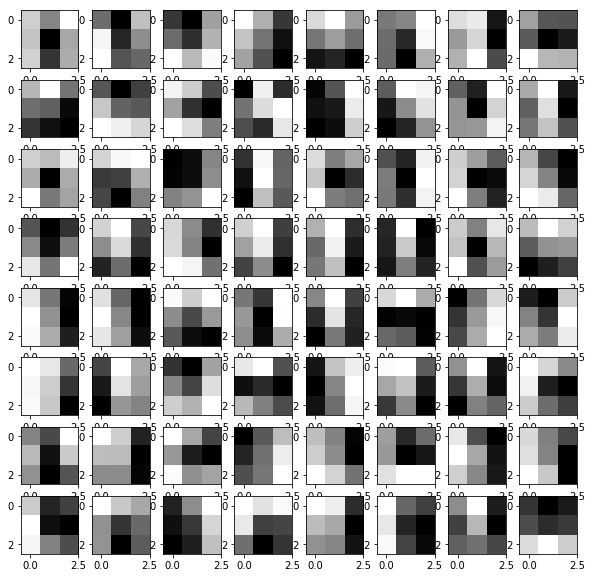

In [14]:
import numpy as np
import matplotlib.pyplot as plt

layer_vars = model.get_layer('block2_conv1').get_weights()

weights = layer_vars[0]
biases = layer_vars[1]

w = np.array(weights)
w.shape
# So there are total 128 filters in 3x3x64 size in block2_conv1 layer. 
# And 64 in the filter size is to directly do convolution of each 3x3 from 64 filter with 64 depths of input tensor. 
# Each of these 64 3x3 filters are there for one and only one depth of the input tensor.
# Each of these 64 filters will be differently trained and hence they will have different values at the end of training.

# Now to visualize each of the 128 filters in 3x3x64 dims we need to shift the axis

w = np.moveaxis(w, 2, 0)
w = np.moveaxis(w, 3, 0)
print(w.shape)

# the total filter in previous layers will be obtained from w.shape[1]
#total_filters_in_prev_layers = 64

#no. of rows and columns of the plot of filters 
cols = 8
rows = 8
# rows * cols > total_filters 

# current_filter = which filter's weights we want to see
current_filter = 100

fig = plt.figure(figsize=(10, 10))

for each_depth in range(w.shape[1]):
    fig.add_subplot(rows, cols, each_depth+1)
    plt.imshow(w[current_filter][each_depth], cmap='gray')

## 2)Visualizing the maximization of weights for optimized input value

In [15]:
#Here I am loading the VGG16 model pretrained on ImageNet from Keras.

from keras import applications
model = applications.VGG16(include_top=False, weights='imagenet')

# include_top = False will provide us VGG16 model without last 3 fully connected layers. 
# The benefit of that is - it will enable us to feed any size of image to the model.

layer_dict = dict([(layer.name, layer) for layer in model.layers])
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### In the cell below I am defining a custom loss function and performing Gradient Ascent
This loss function will seek to maximize the activation of a specific filter (filter_index) in a specific layer (layer_name).I am doing this via a Keras backend function.I am normalizing the gradient of the pixels of the input image, which avoids very small and very large gradients and ensures a smooth gradient ascent process.

In [17]:
from keras import backend as K

input_img = model.input

layer_name = 'block4_conv1'
filter_index = 13          # considering 13th filter in layer 'block4_conv1'.

layer_output = layer_dict[layer_name].output

# Loss function will be the mean of all the values in the output layer filter.
# e.g. the after convolution assume that the shape of output is 96x96 then we'll average out all the values to have a single value
loss_fxn = K.mean(layer_output[:, :, :, filter_index])

# Finding gradient of loss_fxn w.r.t. the input_img
# it will be 256x256 matrix and each value represent the gradient of loss_fxn w.r.t. that particular pixel
gradient = K.gradients(loss_fxn, input_img)[0]

# Normalizing the gradient
# Here I am not subtracting the mean value from the gradient to keep it positive
gradient = gradient / (K.sqrt(K.mean(K.square(gradient))) + 1e-05)

iterate = K.function([input_img], [loss_fxn, gradient])

#### Performing Gradient Ascent

In [19]:
import numpy as np

w = 256
h = 256

input_img_data = np.random.random((1, w, h, 3))*20 + 128
# Random noisy image of dims 1, 3 (channels to visualize RGB), width, heights

step_size = 1
# Step size for gradient to pass to input image. 
# It is similar to learning rate, how much we want to learn from a gradient.

steps = 100
for i in range(steps):
    loss, grads = iterate([input_img_data])
    input_img_data = input_img_data + grads*step_size
    # Here loss will continuously increase as we are adding gradient and we want to move in the direction of 
    # gradient with each iteration input image will get updated and the new gradient will be calculated based 
    # on new image So, we want to see for a given filter which input image (noise) provides higher value of loss 
    # function which is the activation for that filter. So at the end of the iterations we will have an image 
    # which will maximize the activation of a given filter. 
    print("Step: {}/{}, Loss: {}".format(i+1, steps, loss))

Step: 1/100, Loss: 19.807289123535156
Step: 2/100, Loss: 122.6387710571289
Step: 3/100, Loss: 260.4385681152344
Step: 4/100, Loss: 402.8885498046875
Step: 5/100, Loss: 553.182861328125
Step: 6/100, Loss: 707.587890625
Step: 7/100, Loss: 861.2722778320312
Step: 8/100, Loss: 1015.5779418945312
Step: 9/100, Loss: 1168.611572265625
Step: 10/100, Loss: 1319.01416015625
Step: 11/100, Loss: 1466.310546875
Step: 12/100, Loss: 1611.15869140625
Step: 13/100, Loss: 1754.6187744140625
Step: 14/100, Loss: 1894.243408203125
Step: 15/100, Loss: 2031.763916015625
Step: 16/100, Loss: 2167.06201171875
Step: 17/100, Loss: 2301.47314453125
Step: 18/100, Loss: 2432.847900390625
Step: 19/100, Loss: 2562.7861328125
Step: 20/100, Loss: 2690.08984375
Step: 21/100, Loss: 2815.33203125
Step: 22/100, Loss: 2940.275634765625
Step: 23/100, Loss: 3063.761962890625
Step: 24/100, Loss: 3186.39501953125
Step: 25/100, Loss: 3308.27197265625
Step: 26/100, Loss: 3429.7060546875
Step: 27/100, Loss: 3550.33203125
Step: 28/1

In [20]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
img = deprocess_image(img)

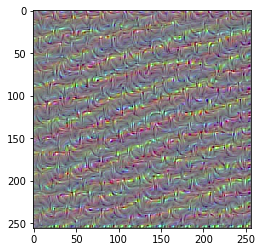

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img)

### I am definining a function to obtain the visualization for different filters in a given layer and save in a folder.
That is the process in the previous few cells obtained visualizations for a single filter.The function below will obtain visualizations for all different filters in a given layer.

In [35]:
from keras import backend as K
import numpy as np
import cv2
import os

def get_filter_visualizations(model, input_w, input_h, layer_name, no_steps, single_filter=False, single_filter_no=0):
    input_image = model.input
    
    my_layer_dict = dict([(layer.name, layer) for layer in model.layers])
    
    if single_filter == False:
        no_filters = np.array(my_layer_dict[layer_name].get_weights()[0]).shape[3]
        
        for i in range(no_filters):
            filter_index = i
            layer_o_p = my_layer_dict[layer_name].output
            loss_ = K.mean(layer_o_p[:, :, :, filter_index])
            grad = K.gradients(loss_, input_image)[0]
            grad = grad / (K.sqrt(K.mean(K.square(grad))) + 1e-05)
            iterate_model = K.function([input_image], [loss_, grad])

            input_noise = np.random.random((1, input_w, input_h, 3))*20 + 128
            step_size = 1

            for j in range(no_steps):
                L, G = iterate_model([input_noise])
                input_noise = input_noise + G*step_size 

            input_noise -= input_noise.mean()
            input_noise /= (input_noise.std() + 1e-5)
            input_noise *= 0.1

            input_noise += 0.5
            input_noise = np.clip(input_noise, 0, 1)

            input_noise *= 255
            input_noise = np.clip(input_noise, 0, 255).astype('uint8')

            input_noise = np.squeeze(input_noise)

            save_path = "./Visualizations/Filter Visualizations_" + layer_name
            file_name = layer_name + "_filter_" + str(filter_index) + ".png"

            if not os.path.exists(save_path):
                os.makedirs(save_path)
            cv2.imwrite(os.path.join(save_path, file_name),input_noise)
    else:
        no_filters = 1
        
        for i in range(no_filters):
            filter_index = single_filter_no
            layer_o_p = my_layer_dict[layer_name].output
            loss_ = K.mean(layer_o_p[:, :, :, filter_index])
            grad = K.gradients(loss_, input_image)[0]
            grad = grad / (K.sqrt(K.mean(K.square(grad))) + 1e-05)
            iterate_model = K.function([input_image], [loss_, grad])

            input_noise = np.random.random((1, input_w, input_h, 3))*20 + 128
            step_size = 1

            for j in range(no_steps):
                L, G = iterate_model([input_noise])
                input_noise = input_noise + G*step_size 

            input_noise -= input_noise.mean()
            input_noise /= (input_noise.std() + 1e-5)
            input_noise *= 0.1

            input_noise += 0.5
            input_noise = np.clip(input_noise, 0, 1)

            input_noise *= 255
            input_noise = np.clip(input_noise, 0, 255).astype('uint8')

            input_noise = np.squeeze(input_noise)

            save_path = "./Visualizations/Filter Visualizations at every layer" + "_" + str(filter_index)
            file_name = layer_name + "_filter_" + str(filter_index) + ".png"

            if not os.path.exists(save_path):
                os.makedirs(save_path)
            cv2.imwrite(os.path.join(save_path, file_name),input_noise)

In [36]:
from keras import applications

model = applications.VGG16(include_top=False, weights='imagenet')

layer_dict = dict([(layer.name, layer) for layer in model.layers])

## Run below code to get the visualization of filters in a particular individual layer.

In [43]:
# Here I am visualizing the all the filters in block5_conv2

get_filter_visualizations(model, 256, 256, 'block5_conv2', 20)

## Run below code to get the visualization of a single filter in each of the layers.

In [ ]:
for i, val in enumerate((list(layer_dict)[1:])):
    get_filter_visualizations(model, 256, 256, val, 20, single_filter=True, single_filter_no=17)

In [ ]:
for i, val in enumerate((list(layer_dict)[1:])):
    get_filter_visualizations(model, 256, 256, val, 20, single_filter=True, single_filter_no=13)